- you can test each algorithm on each dataset by excuting the corresponding section

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../utils/')
import imp
import plot_tools
imp.reload(plot_tools)
import pandas as pd
import networkx as nx
from measures import measures_calculator,matchY
from torchvision import datasets
from collections import  Counter

import api
imp.reload(api)
import time

def set_seed(seed=1):
    import random
    random.seed(seed)
    np.random.seed(seed)

In [2]:
class DataLoader:
    def __init__(self):
        pass
    
    @classmethod
    def load(self,name):
        
        if name=='face':
            from sklearn.datasets import fetch_olivetti_faces
            X, Y_true = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=0)
            return X, Y_true
        
        if name== 'pulsar':
            df=pd.read_csv('../data/real_data/Pulsar.csv', header=None)#类别严重不均衡
            X=df.iloc[:,:-1].values.astype(np.float)
            Y_true=df.iloc[:,-1].values.astype(np.float)
            return X,Y_true
        
        if name== 'sloan':
            df=pd.read_csv('../data/real_data/Sloan.csv', header=None) # kmeans效果最好
            X=df.iloc[:,:-1].values.astype(np.float)
            Y_true = df.iloc[:,-1].values
            Y_true[Y_true == 'STAR'] = 0.
            Y_true[Y_true == 'GALAXY'] = 1.
            Y_true[Y_true == 'QSO'] = 2.
            return X,Y_true
        
        if name== 'rna':
            df=pd.read_csv('../data/real_data/codrna.csv', header=None)
            df=df.fillna(0)
            X=df.iloc[:,:-1].values.astype(np.float)
            Y_true=df.iloc[:,-1].values.astype(np.float)
            Y_true[Y_true == -1] = 0.
            return X,Y_true
    
        if name=='mnist_784':
            dataset2 = datasets.MNIST('../data', train=True, download=True)
            N=dataset2.test_data.shape[0]
            X=dataset2.test_data.numpy().reshape(N,784)/255
            Y_true=dataset2.test_labels.numpy()
            return X,Y_true
        
        if name=='fmnist_784':
            dataset2 = datasets.FashionMNIST('../data', train=True, download=True)
            N=dataset2.test_data.shape[0]
            X=dataset2.test_data.numpy().reshape(N,784)/255
            Y_true=dataset2.test_labels.numpy()
            return X,Y_true
        
        if name=='pbmc3k':
            X=np.load('../data/real_data/pbmc3k_data.npy')
            Y_true=np.load('../data/real_data/pbmc3k_label.npy')
            return X,Y_true
        
        if name=='elegan':
            X=np.load('../data/real_data/elegan_data.npy')
            Y_true=np.load('../data/real_data/elegan_label.npy')
            return X,Y_true
        
        if name=='Frogs_MFCCs':
            df=pd.read_csv('../data/real_data/Frogs_MFCCs.csv')
            X=df.iloc[:,:-4].values.astype(np.float)
#             Y_true = df.iloc[:,-4].values
#             Y_true[Y_true == 'Bufonidae'] = 0.
#             Y_true[Y_true == 'Dendrobatidae'] = 1.
#             Y_true[Y_true == 'Hylidae'] = 2.
#             Y_true[Y_true == 'Leptodactylidae'] = 3.
            Y_true = df.iloc[:,-2].values
            Y_true[Y_true=='AdenomeraAndre']=0
            Y_true[Y_true=='AdenomeraHylaedact']=1
            Y_true[Y_true=='AdenomeraHylaedactylus']=1
            Y_true[Y_true=='Ameeregatrivittata']=2
            Y_true[Y_true=='HylaMinuta']=3
            Y_true[Y_true=='HypsiboasCinerascens']=4
            Y_true[Y_true=='HypsiboasCordobae']=5
            Y_true[Y_true=='LeptodactylusFuscus']=6
            Y_true[Y_true=='OsteocephalusOopha']=7
            Y_true[Y_true=='OsteocephalusOophagus']=7
            Y_true[Y_true=='Rhinellagranulosa']=8
            Y_true[Y_true=='ScinaxRuber']=9
            return X,Y_true
        
        if name=='codon':
            df=pd.read_csv('../data/real_data/codon_usage.csv')
            df=df.replace('-',0)
            X=df.iloc[:,5:].values.astype(np.float)
            Y_true = df.iloc[:,0].values

            Y_true[Y_true=='arc']=0
            Y_true[Y_true=='bct']=1
            Y_true[Y_true=='phg']=2
            Y_true[Y_true=='plm']=3
            Y_true[Y_true=='pln']=4
            Y_true[Y_true=='inv']=5
            Y_true[Y_true=='vrt']=6
            Y_true[Y_true=='mam']=7
            Y_true[Y_true=='rod']=8
            Y_true[Y_true=='pri']=9
            Y_true[Y_true=='vrl']=10
            return X,Y_true

In [3]:
X,Y_true=DataLoader.load('elegan')
print(len(Counter(Y_true)))

37


# Face

## spectral

In [13]:
X,Y_true=DataLoader.load('face')
t1=time.time()
clustering = SpectralClustering(n_clusters=40,
        assign_labels="discretize",
        random_state=0,
        affinity='rbf',#'nearest_neighbors','rbf'
#         n_neighbors=10
        ).fit(X)
t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred=clustering.labels_
result=measures_calculator(Y_true, Y_pred)
result

time:0.34599947929382324


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.372332,0.190878,0.405,0.662987,1.0,30.0


## kmeans

In [14]:
from sklearn.cluster import KMeans
X,Y_true=DataLoader.load('face')
t1=time.time()
kmeans = KMeans(n_clusters=40, random_state=0).fit(X)
Y_pred = kmeans.labels_

t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

time:2.5888872146606445


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.523807,0.376403,0.555,0.742677,1.0,34.0


## HDBSCAN

In [23]:
import hdbscan
X,Y_true=DataLoader.load('face')
t1=time.time()
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=5)
clusterer.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=clusterer.labels_

measures_calculator(Y_true, Y_pred)

0.8972158432006836


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.339305,0.076219,0.358268,0.613563,0.635,19.0


## QuickshiftPP

In [4]:
from QuickshiftPP import *
X,Y_true=DataLoader.load('face')
X=[X[i] for i in range(X.shape[0])]
t1=time.time()
model = QuickshiftPP(k=8,beta=0.5)
model.fit(X)
Y_pred = model.memberships
t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

time:0.8055555820465088


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.595252,0.380508,0.6025,0.788482,1.0,36.0


## SpectACI

In [5]:
from Spectacl import Spectacl
set_seed(2021)
X,Y_true=DataLoader.load('face')
t1=time.time()
s = Spectacl(affinity="radius_neighbors", n_clusters=40, epsilon=10)
Y_pred = s.fit_predict(X)
t2=time.time()
print('time:{}'.format(t2-t1))
# plot_tools.autoPlot(X,Y_pred)
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true, Y_pred)
result

time:1.0670084953308105


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.3424,0.2058,0.37,0.605376,1.0,34.0


## GIT

In [6]:
X,Y_true=DataLoader.load('face')
t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=3,
                  target_ratio=[ 1 for i in range(40)],
                  plot=False,
                 )
t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
print(result)

time:2.0638680458068848
        f1       ARI    ACC       NMI  cover_rate  classes
0  0.62008  0.446851  0.625  0.778978         1.0     38.0


# MNIST

## Spectral

In [5]:
from sklearn.cluster import SpectralClustering
X,Y_true=DataLoader.load('mnist_784')
t1=time.time()
clustering = SpectralClustering(n_clusters=10,
        assign_labels="discretize",
        random_state=0,
        gamma=0.01,
        affinity='rbf',#'nearest_neighbors','rbf', 'radius_neighbors'
#         n_neighbors=10
        ).fit(X)

# clustering = SpectralClustering(n_clusters=10,
#         assign_labels="discretize",
#         random_state=0,
#         eigen_solver='arpack',
#         affinity='nearest_neighbors',#'nearest_neighbors','rbf'
# #         n_neighbors=10
#         ).fit(X)
t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred=clustering.labels_
result=measures_calculator(Y_true, Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



KeyboardInterrupt: 

In [9]:
from sklearn.cluster import SpectralClustering
X,Y_true=DataLoader.load('mnist_784')
t1=time.time()
clustering = SpectralClustering(n_clusters=10,
        assign_labels="discretize",
        random_state=0,
        gamma=0.01,
        affinity='rbf',#'nearest_neighbors','rbf'
#         n_neighbors=10
        ).fit(X)

# clustering = SpectralClustering(n_clusters=10,
#         assign_labels="discretize",
#         random_state=0,
#         eigen_solver='arpack',
#         affinity='nearest_neighbors',#'nearest_neighbors','rbf'
# #         n_neighbors=10
#         ).fit(X)
t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred=clustering.labels_
result=measures_calculator(Y_true, Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



time:407.66722893714905


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.412215,0.327832,0.4229,0.436736,1.0,10.0


## KMeans

In [7]:
from sklearn.cluster import KMeans
X,Y_true=DataLoader.load('mnist_784')
t1=time.time()
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)
Y_pred = kmeans.labels_
t2=time.time()
print('time:{}'.format(t2-t1))

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



time:76.66926503181458


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.503281,0.360887,0.508533,0.490671,1.0,10.0


## HDBSCAN

In [8]:
import hdbscan
X,Y_true=DataLoader.load('mnist_784')
t1=time.time()
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=1)
clusterer.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=clusterer.labels_

measures_calculator(Y_true, Y_pred)

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



2036.957825422287


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.990657,0.996263,0.985385,0.988566,0.215533,10.0


## QuickshiftPP

In [9]:
from QuickshiftPP import *
X,Y_true=DataLoader.load('mnist_784')
X=[X[i] for i in range(X.shape[0])]
t1=time.time()
model = QuickshiftPP(k=50,beta=0.5)
model.fit(X)
t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred = model.memberships
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



time:3384.0855956077576


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.45017,0.132214,0.42215,0.447108,1.0,11.0


In [9]:
from QuickshiftPP import *
X,Y_true=DataLoader.load('mnist_784')
X=[X[i] for i in range(X.shape[0])]
t1=time.time()
model = QuickshiftPP(k=100,beta=0.5)
model.fit(X)
t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred = model.memberships
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



time:3186.813917160034


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.626089,0.371214,0.610767,0.57412,1.0,11.0


## SpectACI

In [7]:
from Spectacl import Spectacl
set_seed(2021)
X,Y_true=DataLoader.load('mnist_784')
t1=time.time()
s = Spectacl(affinity="radius_neighbors", n_clusters=10, epsilon=8) #'radius_neighbors'
Y_pred = s.fit_predict(X)
t2=time.time()
print('time:{}'.format(t2-t1))
# plot_tools.autoPlot(X,Y_pred)
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true, Y_pred)
result

KeyboardInterrupt: 

## GIT

In [3]:
X,Y_true=DataLoader.load('mnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=40,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



422.1417679786682


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.585946,0.415687,0.586067,0.533214,1.0,10.0


# FMNIST

## Spectral

In [32]:
X,Y_true=DataLoader.load('fmnist_784')

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



In [10]:
X,Y_true=DataLoader.load('fmnist_784')
t1=time.time()
clustering = SpectralClustering(n_clusters=10,
        assign_labels="discretize",
        random_state=0,
        gamma=0.01,
        affinity='rbf',#'nearest_neighbors','rbf'
#         n_neighbors=10
        ).fit(X)
t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred=clustering.labels_
result=measures_calculator(Y_true, Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



time:397.7027552127838


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.432468,0.340118,0.45335,0.490392,1.0,10.0


## KMeans

In [12]:
from sklearn.cluster import KMeans
X,Y_true=DataLoader.load('fmnist_784')
t1=time.time()
kmeans = KMeans(n_clusters=10, random_state=2021).fit(X)
Y_pred = kmeans.labels_
t2=time.time()
print('time:{}'.format(t2-t1))

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



time:54.589123010635376


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.388148,0.347897,0.4332,0.511784,1.0,10.0


## HDBSCAN

In [13]:
import hdbscan
X,Y_true=DataLoader.load('fmnist_784')
t1=time.time()
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=1)
clusterer.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=clusterer.labels_

measures_calculator(Y_true, Y_pred)

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



1647.909056186676


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.059648,0.008687,0.173016,0.069865,0.569217,3.0


## QuickshiftPP

In [14]:
from QuickshiftPP import *
X,Y_true=DataLoader.load('fmnist_784')
X=[X[i] for i in range(X.shape[0])]
t1=time.time()
model = QuickshiftPP(k=100,beta=0.5)
model.fit(X)
t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred = model.memberships
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



time:3832.566859960556


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.41524,0.161233,0.389183,0.406009,1.0,11.0


## SpectACI

In [15]:
from Spectacl import Spectacl
set_seed(2021)
X,Y_true=DataLoader.load('fmnist_784')
t1=time.time()
s = Spectacl(affinity="radius_neighbors", n_clusters=10, epsilon=8)
Y_pred = s.fit_predict(X)
t2=time.time()
print(t2-t1)
# plot_tools.autoPlot(X,Y_pred)
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true, Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



4730.229597330093


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.473277,0.288514,0.483767,0.449836,1.0,10.0


## GIT

In [4]:
X,Y_true=DataLoader.load('fmnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=80,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



465.50349521636963


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.56107,0.319797,0.550583,0.506752,1.0,10.0


In [30]:
X,Y_true=DataLoader.load('fmnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=70,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



472.82115602493286


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.506698,0.319694,0.515517,0.494904,1.0,10.0


In [10]:
X,Y_true=DataLoader.load('fmnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=60,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



463.95729422569275


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.507679,0.325693,0.515633,0.497414,1.0,10.0


In [29]:
X,Y_true=DataLoader.load('fmnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=80,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



509.9714822769165


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.56107,0.319797,0.550583,0.506752,1.0,10.0


In [28]:
X,Y_true=DataLoader.load('fmnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=90,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



442.4476659297943


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.556201,0.312896,0.54605,0.50175,1.0,10.0


In [16]:
X,Y_true=DataLoader.load('fmnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=100,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



444.4763994216919


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.551863,0.298914,0.5376,0.497531,1.0,10.0


# Frogs_MFCCs

## Spectral

In [14]:
X,Y_true=DataLoader.load('Frogs_MFCCs')
t1=time.time()
clustering = SpectralClustering(n_clusters=10,
        assign_labels="discretize",
        random_state=0,
        affinity='rbf',#'nearest_neighbors','rbf'
#         n_neighbors=10
        ).fit(X)
t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred=clustering.labels_
result=measures_calculator(Y_true, Y_pred)
result

time:3.665275812149048


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.602745,0.412804,0.535928,0.59863,1.0,10.0


## KMeans

In [15]:
from sklearn.cluster import KMeans
X,Y_true=DataLoader.load('Frogs_MFCCs')
t1=time.time()
kmeans = KMeans(n_clusters=10, random_state=2021).fit(X)
Y_pred = kmeans.labels_

t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

time:0.1770029067993164


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.468953,0.403534,0.404864,0.614154,1.0,10.0


## HDBSCAN

In [26]:
import hdbscan
X,Y_true=DataLoader.load('Frogs_MFCCs')
t1=time.time()
clusterer = hdbscan.HDBSCAN(min_cluster_size=80, min_samples=20)
clusterer.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=clusterer.labels_

measures_calculator(Y_true, Y_pred)

1.6628048419952393


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.945024,0.964684,0.933463,0.933733,0.783322,9.0


## QuickshiftPP

In [17]:
from QuickshiftPP import *
X,Y_true=DataLoader.load('Frogs_MFCCs')
X=[X[i] for i in range(X.shape[0])]
t1=time.time()
model = QuickshiftPP(k=30,beta=0.5)
model.fit(X)
t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred = model.memberships
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

time:0.54323410987854


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.503963,0.213322,0.454343,0.457929,1.0,11.0


## SpectACI

In [18]:
from Spectacl import Spectacl
set_seed(2021)
X,Y_true=DataLoader.load('Frogs_MFCCs')
t1=time.time()
s = Spectacl(affinity="radius_neighbors", n_clusters=10, epsilon=0.5)
Y_pred = s.fit_predict(X)
t2=time.time()
print('time:{}'.format(t2-t1))
# plot_tools.autoPlot(X,Y_pred)
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true, Y_pred)
result

time:2.880692958831787


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.601038,0.487481,0.526477,0.603438,1.0,8.0


## GIT

In [19]:
X,Y_true=DataLoader.load('Frogs_MFCCs')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=18,
                  target_ratio=[672,3478,542,310,472,1121,270,114,68,148],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

3.229247808456421


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.662246,0.688486,0.626129,0.663295,1.0,9.0


# codon

In [6]:
X,Y_true=DataLoader.load('codon')
Counter(Y_true)

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning:

Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.



Counter({10: 2832,
         0: 126,
         1: 2920,
         2: 220,
         3: 18,
         4: 2523,
         5: 1345,
         6: 2077,
         7: 572,
         8: 215,
         9: 180})

In [7]:
18/2832

0.006355932203389831

In [8]:
X.shape

(13028, 64)

## Spectral

In [20]:
X,Y_true=DataLoader.load('codon')
t1=time.time()
clustering = SpectralClustering(n_clusters=11,
        assign_labels="discretize",
        random_state=0,
        affinity='rbf',#'nearest_neighbors','rbf'
#         n_neighbors=10
        ).fit(X)
t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred=clustering.labels_
result=measures_calculator(Y_true, Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning:

Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.



time:11.642885446548462


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.368555,0.236093,0.30588,0.371481,1.0,11.0


## KMeans

In [21]:
from sklearn.cluster import KMeans
X,Y_true=DataLoader.load('codon')
t1=time.time()
kmeans = KMeans(n_clusters=11, random_state=0).fit(X)
Y_pred = kmeans.labels_

t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning:

Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.



time:1.1185762882232666


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.244667,0.186131,0.243629,0.334353,1.0,10.0


## HDBSACN

In [22]:
import hdbscan
X,Y_true=DataLoader.load('codon')
t1=time.time()
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=5)
clusterer.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=clusterer.labels_

measures_calculator(Y_true, Y_pred)

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning:

Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.



10.195638418197632


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.210377,0.048093,0.124445,0.235466,0.346024,501.0


## QuickshiftPP

In [23]:
from QuickshiftPP import *
X,Y_true=DataLoader.load('codon')
X=[X[i] for i in range(X.shape[0])]
t1=time.time()
model = QuickshiftPP(k=20,beta=0.5)
model.fit(X)
Y_pred = model.memberships
t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning:

Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.



time:7.914399147033691


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.240904,0.043718,0.298127,0.211771,1.0,12.0


## SpectACI

In [184]:
np.linalg.norm(X,axis=1)

array([0.16186769, 0.16193915, 0.13693939, ..., 0.18748197, 0.141514  ,
       0.16742108])

In [24]:
from Spectacl import Spectacl
set_seed(2021)
X,Y_true=DataLoader.load('codon')
t1=time.time()
s = Spectacl(affinity="radius_neighbors", n_clusters=11, epsilon=0.5)
Y_pred = s.fit_predict(X)
t2=time.time()
print('time:{}'.format(t2-t1))
# plot_tools.autoPlot(X,Y_pred)
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true, Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning:

Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.



time:82.40712332725525


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.199035,0.018893,0.185984,0.025058,1.0,11.0


## GIT

In [25]:
X,Y_true=DataLoader.load('codon')
t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=15,
                  target_ratio=[ 2832,126,2920,220,18,2523,1345,2077,572,215,180 ],
                  plot=False,
                 )
t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
print(result)

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning:

Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.



time:16.07431697845459
         f1       ARI      ACC       NMI  cover_rate  classes
0  0.453842  0.306964  0.46331  0.387641         1.0      9.0


# MoCap

In [217]:
df=pd.read_csv('./real_data/MoCap.csv')
df=df.replace('?',0)
X = df.iloc[1:,2:17].values.astype(np.float)
Y_true = df.iloc[1:,0].values

In [218]:
Counter(Y_true)

Counter({1: 16265, 2: 14978, 3: 16344, 4: 14775, 5: 15733})

- kmeans

In [219]:
from sklearn.cluster import KMeans
t1=time.time()
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
Y_pred = kmeans.labels_

t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

time:1.232332468032837


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.458339,0.198475,0.473078,0.203934,1.0,5.0


- GIT

In [ ]:
t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=30,
                  target_ratio=[ 16265,14978,16344,14775, 15733],
                  plot=False,
                 )
t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
print(result)

# Online_Shoppers

# GIT

## face

## mnist

In [57]:
X,Y_true=DataLoader.load('mnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=20,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



636.9293773174286


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.22867,0.162894,0.2784,0.412157,1.0,10.0


In [55]:
X,Y_true=DataLoader.load('mnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=25,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



497.205614566803


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.458777,0.344877,0.50675,0.52894,1.0,10.0


In [56]:
X,Y_true=DataLoader.load('mnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=50,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



400.441326379776


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.493965,0.367416,0.510233,0.518134,1.0,10.0


In [66]:
X,Y_true=DataLoader.load('mnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=60,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



398.3319990634918


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.429582,0.333563,0.458733,0.485325,1.0,10.0


In [68]:
X,Y_true=DataLoader.load('mnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=65,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



428.05471658706665


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.430436,0.366788,0.466283,0.504185,1.0,10.0


In [65]:
X,Y_true=DataLoader.load('mnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=70,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



431.6699995994568


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.536942,0.357504,0.5442,0.497158,1.0,10.0


In [67]:
X,Y_true=DataLoader.load('mnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=75,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



432.1495723724365


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.483751,0.329933,0.497017,0.464568,1.0,10.0


In [59]:
X,Y_true=DataLoader.load('mnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=80,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



430.5973563194275


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.482268,0.306115,0.493283,0.466603,1.0,10.0


In [63]:
X,Y_true=DataLoader.load('mnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=90,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



434.0591344833374


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.512241,0.357698,0.52125,0.457319,1.0,10.0


In [58]:
X,Y_true=DataLoader.load('mnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=100,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



437.3194143772125


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.518845,0.354786,0.523117,0.456086,1.0,10.0


In [64]:
X,Y_true=DataLoader.load('mnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=110,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



404.7560603618622


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.469608,0.317331,0.480333,0.428577,1.0,10.0


In [61]:
X,Y_true=DataLoader.load('mnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=120,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



409.57226061820984


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.409792,0.262345,0.42365,0.398569,1.0,10.0


In [62]:
X,Y_true=DataLoader.load('mnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=150,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



416.6392984390259


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.420667,0.285487,0.433567,0.436986,1.0,10.0


In [60]:
X,Y_true=DataLoader.load('mnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=200,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



427.33039593696594


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.486284,0.276972,0.483767,0.420009,1.0,10.0


## pbmc3k

Counter({0: 31375, 32: 17520, 23: 7746, 11: 6090, 19: 4468, 1: 2766, 15: 2562, 8: 1857, 9: 1732, 24: 1471, 16: 911, 29: 787, 20: 786, 31: 768, 36: 568, 34: 499, 5: 493, 7: 434, 17: 372, 4: 327, 10: 315, 27: 273, 35: 265, 14: 215, 30: 205, 6: 189, 22: 155, 28: 141, 21: 122, 33: 114, 26: 112, 12: 91, 18: 75, 2: 72, 25: 62, 13: 61, 3: 25})
1288.3930253982544


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.185056,0.079809,0.251407,0.22022,1.0,16.0


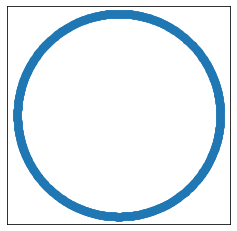

In [23]:
X,Y_true=DataLoader.load('elegan')
print(Counter(Y_true))

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=10,
                  target_ratio=[ 1 for i in range(16)],
                  plot=True,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

## fmnist

In [18]:
X,Y_true=DataLoader.load('fmnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=50,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



440.2051246166229


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.406475,0.322433,0.4332,0.509125,1.0,10.0


In [21]:
X,Y_true=DataLoader.load('fmnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=60,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



461.5079834461212


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.400181,0.298724,0.436167,0.509006,1.0,10.0


In [14]:
X,Y_true=DataLoader.load('fmnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=70,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



443.65528321266174


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.389934,0.265485,0.421783,0.490407,1.0,10.0


In [20]:
X,Y_true=DataLoader.load('fmnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=80,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



442.3829700946808


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.393991,0.265376,0.4256,0.496561,1.0,10.0


In [19]:
X,Y_true=DataLoader.load('fmnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=90,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



440.7137315273285


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.41951,0.299929,0.451533,0.495954,1.0,10.0


In [24]:
X,Y_true=DataLoader.load('fmnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=95,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



444.0820391178131


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.399039,0.267107,0.428417,0.470206,1.0,10.0


In [15]:
X,Y_true=DataLoader.load('fmnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=100,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



464.7928030490875


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.432244,0.293361,0.444467,0.495246,1.0,10.0


In [23]:
X,Y_true=DataLoader.load('fmnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=120,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



445.54121923446655


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.419587,0.247523,0.4422,0.465729,1.0,10.0


In [16]:
X,Y_true=DataLoader.load('fmnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=150,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



450.76680159568787


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.424018,0.26534,0.44165,0.475032,1.0,10.0


In [17]:
X,Y_true=DataLoader.load('fmnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend,draw_tasks,final_cluster=api.GIT.fit(  X,
                  k=200,
                  target_ratio=[ 1 for i in range(10)],
                  plot=False,
                 )
t2=time.time()
print(t2-t1)

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



456.2954890727997


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.399529,0.228018,0.427633,0.454589,1.0,10.0


# k-means

In [21]:
from sklearn.cluster import KMeans

## mnist

In [70]:
X,Y_true=DataLoader.load('mnist_784')
t1=time.time()
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)
Y_pred = kmeans.labels_
t2=time.time()
print('time:{}'.format(t2-t1))

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



time:17.01878023147583


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.503267,0.360876,0.508517,0.490661,1.0,10.0


## pbmc3k

In [22]:
Counter(Y_true)

Counter({32: 17520,
         0: 31375,
         11: 6090,
         24: 1471,
         23: 7746,
         19: 4468,
         15: 2562,
         1: 2766,
         9: 1732,
         31: 768,
         34: 499,
         14: 215,
         5: 493,
         20: 786,
         16: 911,
         17: 372,
         27: 273,
         33: 114,
         18: 75,
         36: 568,
         2: 72,
         13: 61,
         8: 1857,
         21: 122,
         12: 91,
         6: 189,
         29: 787,
         22: 155,
         35: 265,
         25: 62,
         26: 112,
         10: 315,
         4: 327,
         7: 434,
         30: 205,
         3: 25,
         28: 141})

In [37]:
X,Y_true=DataLoader.load('elegan')
t1=time.time()
kmeans = KMeans(n_clusters=37, random_state=0).fit(X)
Y_pred = kmeans.labels_
t2=time.time()
print('time:{}'.format(t2-t1))

Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

time:12.007062673568726


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.390498,0.142016,0.460767,0.316165,1.0,16.0


# QuickshiftPP

In [19]:
from QuickshiftPP import *

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



## face

In [32]:
X,Y_true=DataLoader.load('face')
X=[X[i] for i in range(X.shape[0])]
t1=time.time()
model = QuickshiftPP(k=8,beta=0.5)
model.fit(X)
Y_pred = model.memberships
t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

time:0.7375469207763672


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.595252,0.380508,0.6025,0.788482,1.0,36.0


## mnist

In [ ]:
X,Y_true=DataLoader.load('mnist_784')
X=[X[i] for i in range(X.shape[0])]
t1=time.time()
model = QuickshiftPP(k=100,beta=0.5)
model.fit(X)
t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred = model.memberships
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



## fmnist

In [20]:
X,Y_true=DataLoader.load('elegan')
X=[X[i] for i in range(X.shape[0])]
t1=time.time()
model = QuickshiftPP(k=20,beta=0.5)
model.fit(X)
t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred = model.memberships
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

time:298.81561613082886


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.218346,0.004674,0.230854,0.257062,1.0,38.0


In [60]:
X,Y_true=DataLoader.load('pbmc3k')

X=[X[i] for i in range(X.shape[0])]
t1=time.time()
model = QuickshiftPP(k=20,beta=0.7)
model.fit(X)
t2=time.time()
print('time:{}'.format(t2-t1))
Y_pred = model.memberships
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true,Y_pred)
result

time:0.3916621208190918


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.591606,0.32824,0.575436,0.427905,1.0,9.0


# Spectacl

In [9]:
from Spectacl import Spectacl

## face

In [102]:
np.linalg.norm(X[0]-X).max()

240.05353

In [37]:
set_seed(2021)
X,Y_true=DataLoader.load('face')
t1=time.time()
s = Spectacl(affinity="radius_neighbors", n_clusters=40, epsilon=10)
Y_pred = s.fit_predict(X)
t2=time.time()
print('time:{}'.format(t2-t1))
# plot_tools.autoPlot(X,Y_pred)
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true, Y_pred)
result

time:1.0952873229980469


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.3424,0.2058,0.37,0.605376,1.0,34.0


In [ ]:
set_seed(2021)
X,Y_true=DataLoader.load('face')
s = Spectacl(affinity="radius_neighbors", n_clusters=40, epsilon=10)
Y_pred = s.fit_predict(X)
# plot_tools.autoPlot(X,Y_pred)
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true, Y_pred)
result

## mnist

In [6]:
np.linalg.norm(X[0]-X).max()

2479.6223092766545

In [4]:
set_seed(2021)
X,Y_true=DataLoader.load('mnist_784')
t1=time.time()
s = Spectacl(affinity="radius_neighbors", n_clusters=10, epsilon=8)
Y_pred = s.fit_predict(X)
t2=time.time()
print('time:{}'.format(t2-t1))
# plot_tools.autoPlot(X,Y_pred)
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true, Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



time:3946.446084022522


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.399094,0.169543,0.3892,0.326937,1.0,10.0


## fmnist

In [16]:
set_seed(2021)
X,Y_true=DataLoader.load('pbmc3k')
s = Spectacl(affinity="radius_neighbors", n_clusters=8, epsilon=5)
Y_pred = s.fit_predict(X)
# plot_tools.autoPlot(X,Y_pred)
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true, Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:1122: ConvergenceWarning:

Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate points in X.



,f1,ARI,ACC,NMI,cover_rate,classes
0,0.254992,0.0,0.426459,8.220644e-16,1.0,1.0


In [26]:
set_seed(2021)
X,Y_true=DataLoader.load('fmnist_784')
s = Spectacl(affinity="radius_neighbors", n_clusters=10, epsilon=8)
Y_pred = s.fit_predict(X)
# plot_tools.autoPlot(X,Y_pred)
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true, Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



,f1,ARI,ACC,NMI,cover_rate,classes
0,0.473351,0.288627,0.483883,0.449897,1.0,10.0


In [27]:
set_seed(2021)
X,Y_true=DataLoader.load('fmnist_784')
s = Spectacl(affinity="radius_neighbors", n_clusters=10, epsilon=9)
Y_pred = s.fit_predict(X)
# plot_tools.autoPlot(X,Y_pred)
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true, Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



,f1,ARI,ACC,NMI,cover_rate,classes
0,0.446892,0.276867,0.450783,0.426338,1.0,10.0


In [25]:
set_seed(2021)
X,Y_true=DataLoader.load('fmnist_784')
t1=time.time()
s = Spectacl(affinity="radius_neighbors", n_clusters=10, epsilon=10)
Y_pred = s.fit_predict(X)
t2=time.time()
print('time:{}'.format(t2-t1))
# plot_tools.autoPlot(X,Y_pred)
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true, Y_pred)
result

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



time:4821.335472345352


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.375514,0.235957,0.382417,0.392306,1.0,10.0


# HDBSCAN

## face

In [13]:
import hdbscan
X,Y_true=DataLoader.load('face')
t1=time.time()
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=5)
clusterer.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=clusterer.labels_

measures_calculator(Y_true, Y_pred)

0.8630878925323486


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.339305,0.076219,0.358268,0.613563,0.635,19.0


## mnist

In [6]:
import hdbscan
X,Y_true=DataLoader.load('mnist_784')
t1=time.time()
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=1)
clusterer.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=clusterer.labels_

measures_calculator(Y_true, Y_pred)

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



2061.2073130607605


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.990657,0.996263,0.985385,0.988566,0.215533,10.0


## fmnist

In [ ]:
import hdbscan
X,Y_true=DataLoader.load('fmnist_784')
t1=time.time()
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=1)
clusterer.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=clusterer.labels_

measures_calculator(Y_true, Y_pred)

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets

